In [1]:
import os
import numpy as np
import scipy.io.wavfile as wav
from matplotlib import pyplot as plt
import scipy.fftpack
from matplotlib import pylab as pt
import scipy
import matplotlib.image as img
import os

In [2]:
def get_input_size(adir):
    file_names = [f for f in os.listdir(audio_dir) if '.wav' in f]
    ylen   = np.zeros((len(file_names),1))
    maxy   = np.zeros((len(file_names),1))
    i=0
    for f in file_names:
       #Get Audio Features
        audio_path = os.path.join(adir,f)
        sample_rate, samples = wav.read(audio_path)


        # Number of samplepoints
        N = len(samples)
        # sample spacing
        T = 1.0 / sample_rate
        x = np.linspace(0.0, N*T, N)
        y = samples
        yf = scipy.fftpack.fft(y)
        xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
        yy = 2.0/N * np.abs(yf[:N//2])
        ylen[i] = len(yy)   
        maxy[i] = max(yy)
        #print(maxy[i])
        i+=1
        
    min_points = min(ylen)
    max_yy    = max(maxy)
    print("Input Size:", min_points)
    print("Max Height:", max_yy)

    return min_points

In [3]:
def slice_arr(arr,final_size):
    len_arr = len(arr)
    step=0
    step = int(len_arr/final_size)
    farr = arr[::step]
    final_arr = farr[:final_size]
    #final_arr = final_arr[::14]
    #if(len(final_arr)!=final_size):
    #    print(len_arr,len(final_arr), final_size, step)
    return final_arr

In [4]:
def process_audio_dir(adir, sdir, i_s):
    file_names = [f for f in os.listdir(audio_dir) if '.wav' in f]
    file_names.sort()
    file_names_sub = file_names[0:3]
    labels = np.zeros((len(file_names),1))
    xdata  = np.zeros((len(file_names),int(i_s[0])))
    ylen   = np.zeros((len(file_names),1))
    print(labels.shape)
    i=0
    for f in file_names:
        #Extract Label from Name
        first_alpha = f[0]
        labels[i] = int(first_alpha)
        
        #Get Audio Features
        audio_path = os.path.join(adir,f)
        sample_rate, samples = wav.read(audio_path)


        # Number of samplepoints
        N = len(samples)
        # sample spacing
        T = 1.0 / sample_rate
        x = np.linspace(0.0, N*T, N)
        y = samples
        yf = scipy.fftpack.fft(y)
        xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
        yy = 2.0/N * np.abs(yf[:N//2])
        ylen[i] = len(yy)            
        xdata[i,:] = slice_arr(yy,int(i_s[0]))
        filename = os.path.join(sdir, str(i)+'.png')
        if(os.path.isfile(filename)):    
            print("Skipping File No.",i)
        else:
            plt.plot(xdata[i,:])
            plt.savefig()
            plt.show()
        
        i+=1
    return labels, xdata

In [5]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [6]:
def build_dataset(ds,sdir):
    #out_ds = np.zeros((2000,115,41))
    #out_ds = np.zeros((2000,1435,574))
    out_ds  = np.zeros((2000,205,290))
    for i in range(2000):
        if(i%200==0):
            print((float(i)/20),"% Complete")
        #row = list(ds[i,:])
        
        ima = img.imread(os.path.join(sdir, str(i)+'.png'))
        j=0
        im = rgb2gray(ima) 
        #print(im.shape)
        #for elem in row:
        #    #k = int(elem/25)
        #    #k = int(elem/2)
        #    k = int(elem)
        #    out_ds[i,k,j]=1
        #    j+=1
        out_ds[i,:,:] = im[40:245,60:350]
        i+=1
        #print("")     
            
    return out_ds

C:\Users\prate\Anaconda2\envs\MyEnvDL\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


Input Size: [574.]
Max Height: [2869.53128619]
(2000, 1)


C:\Users\prate\Anaconda2\envs\MyEnvDL\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


TypeError: savefig() missing 1 required positional argument: 'fname'

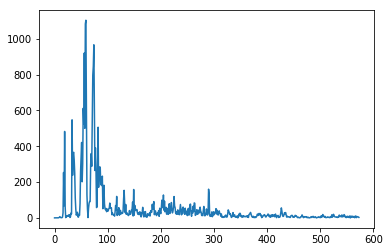

In [8]:
if __name__ == '__main__':
    os.environ['KMP_DUPLICATE_LIB_OK']='True'
    audio_dir = "./recordings/"
    spectrogram_dir = "./spectrograms/"
    if not os.path.exists(spectrogram_dir):
        os.makedirs(spectrogram_dir)
    i_size = get_input_size(audio_dir)
    labels, xdata = process_audio_dir(audio_dir, spectrogram_dir,i_size)
    print(xdata.shape)
    #print(xdata[100,:])
    final_data = build_dataset(xdata, spectrogram_dir)
    print(final_data.shape)
#    for i in range(100):
#        I = final_data[i,:,:]
#        pt.imshow(np.transpose(I), cmap='Greys')
#        pt.show()
    

In [8]:
# Importing the required Keras modules containing model and layers

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
import tensorflow as tf

Using TensorFlow backend.


In [13]:
x_train = final_data[0:1950, :, :]
x_test = final_data[1950:2000, :, :]
y_train = labels[0:1950]
y_test  = labels[1950:2000]
# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = x_train.reshape(x_train.shape[0], 205,290, 1)
x_test = x_test.reshape(x_test.shape[0], 205,290, 1)
input_shape = (205,290, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (1950, 205, 290, 1)
Number of images in x_train 1950
Number of images in x_test 50


In [48]:
# Creating a Sequential Model and adding the layers

model = Sequential()
#model.add(Conv2D(32, kernel_size=(5,5), input_shape=input_shape))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(5,5), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
#model.add(Dense(128, activation=tf.nn.relu))
model.add(Dense(256, activation=tf.nn.softmax))
model.add(Dropout(0.1))
model.add(Dense(10,activation=tf.nn.softmax))

In [49]:
#Compile the model

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [50]:

model.fit(x=x_train,y=y_train, epochs=10)

Epoch 1/10


KeyboardInterrupt: 